In [89]:
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 

In [91]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### DEFAULT CONFIG

In [92]:
config = ml_collections.ConfigDict()

# Data params. 
config.n_samples=10_000
config.input_steps=1
config.output_delay=8 # predict 24 hrs into the future 
config.output_steps=4
config.timestep_duration=3 # equivalent to 3 hours
# note a 3 hour timestep resolution would be 5*24/3=40
# if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    # number of timesteps strictly between the end 
    # of one full sample and the start of the next sample
config.time_resolution=120 # the number of 
            # raw data points generated per time unit, equivalent to the 
            # number of data points generated per 5 days in the simulation
config.init_buffer_samples=100
config.train_pct=0.7
config.val_pct=0.2
config.test_pct=0.1
config.K=36
config.F=8
config.c=10
config.b=10
config.h=1
config.seed=42
config.normalize=True
config.fully_connected_edges=True

# Optimizer.
config.optimizer = 'adam'
config.learning_rate = 1e-3

# Training hyperparameters.
# config.batch_size = 3
config.epochs = 2
config.log_every_epochs = 1
config.eval_every_epochs = 1
config.checkpoint_every_epochs = 1
config.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config.model = 'MLPGraphNetwork'
config.n_blocks = 1
config.activation = 'relu'
config.dropout_rate = 0.1
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config.node_features = (32, 2)
config.global_features = None
config.share_params = False

In [93]:
CHECKPOINT_PATH = "/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning"

In [95]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    # Data params. 
    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=True
    config.max_checkpts_to_keep = None     # none means all

    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 3e-5, 3e-4, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = 0.5 # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 200
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = trial.suggest_int('n_blocks', 1, 3)
    config.share_params = False
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.2)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    # config.activation = "leaky_relu"
    
    config.pred_x1 = True
    config.pred_x2 = True

    if config.pred_x1 and config.pred_x2:
        output_layer = 2
    else:
        output_layer = 1

    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 6), 
        # 2**trial.suggest_int("node_mlp_2_power", 1, 6), 
        output_layer) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    return eval_metrics_dict['val'].compute()['loss']

In [97]:
datasets = create_dataset(config)

In [98]:
def prepare_study(study_name):
    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

In [100]:
# get study
mia1, objective_partial = prepare_study(study_name="hparam_mia4")

[I 2024-05-20 16:31:09,176] A new study created in RDB with name: hparam_mia4


In [101]:
mia1.optimize(objective_partial, 
                n_trials=5-len(mia1.trials), 
                n_jobs=1)

ERROR:absl:Could not start profiling: Profile has already been started. Only one profile may be run at a time.
Traceback (most recent call last):
  File "/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/clu/periodic_actions.py", line 327, in _start_session
    profiler.start(logdir=self._logdir)
  File "/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/clu/profiler.py", line 38, in start
    jax.profiler.start_trace(logdir)
  File "/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/jax/_src/profiler.py", line 119, in start_trace
    raise RuntimeError("Profile has already been started. "
RuntimeError: Profile has already been started. Only one profile may be run at a time.
[W 2024-05-20 16:50:42,938] Trial 0 failed with parameters: {'optimizer': 'adam', 'learning_rate': 5.9052192198041096e-05, 'n_blocks': 3, 'dropout_rate': 0.03035239157348253, 'activation': 'elu', 'edge_mlp_1_power

KeyboardInterrupt: 

In [85]:
mia1.trials

[FrozenTrial(number=0, state=1, values=[556.2626953125], datetime_start=datetime.datetime(2024, 5, 20, 16, 23, 39, 57273), datetime_complete=datetime.datetime(2024, 5, 20, 16, 23, 47, 251802), params={'optimizer': 'adam', 'learning_rate': 4.22602626453734e-05, 'n_blocks': 2, 'dropout_rate': 0.1932613076869926, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 4}, user_attrs={}, system_attrs={}, intermediate_values={0: 123042.296875, 5: 81916.8515625, 10: 57060.203125, 15: 41261.6015625, 20: 30887.984375, 25: 23216.75390625, 30: 17493.1171875, 35: 13563.6318359375, 40: 10632.576171875, 45: 8666.8515625, 50: 6981.8076171875, 55: 6056.22607421875, 60: 5188.3125, 65: 4768.72998046875, 70: 4234.13671875, 75: 3816.6630859375, 80: 3336.090087890625, 85: 3008.95458984375, 90: 2646.14208984375, 95: 2426.70751953125, 100: 2072.73486328125, 105: 1844.9996337890625, 110: 1757.250732421875, 115: 1543.765869140625, 120: 1543.64697265625, 125: 1429.81176757

plot best trial

Checkpoint directory: /Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning/hparam_mia3/trial_2/checkpoints


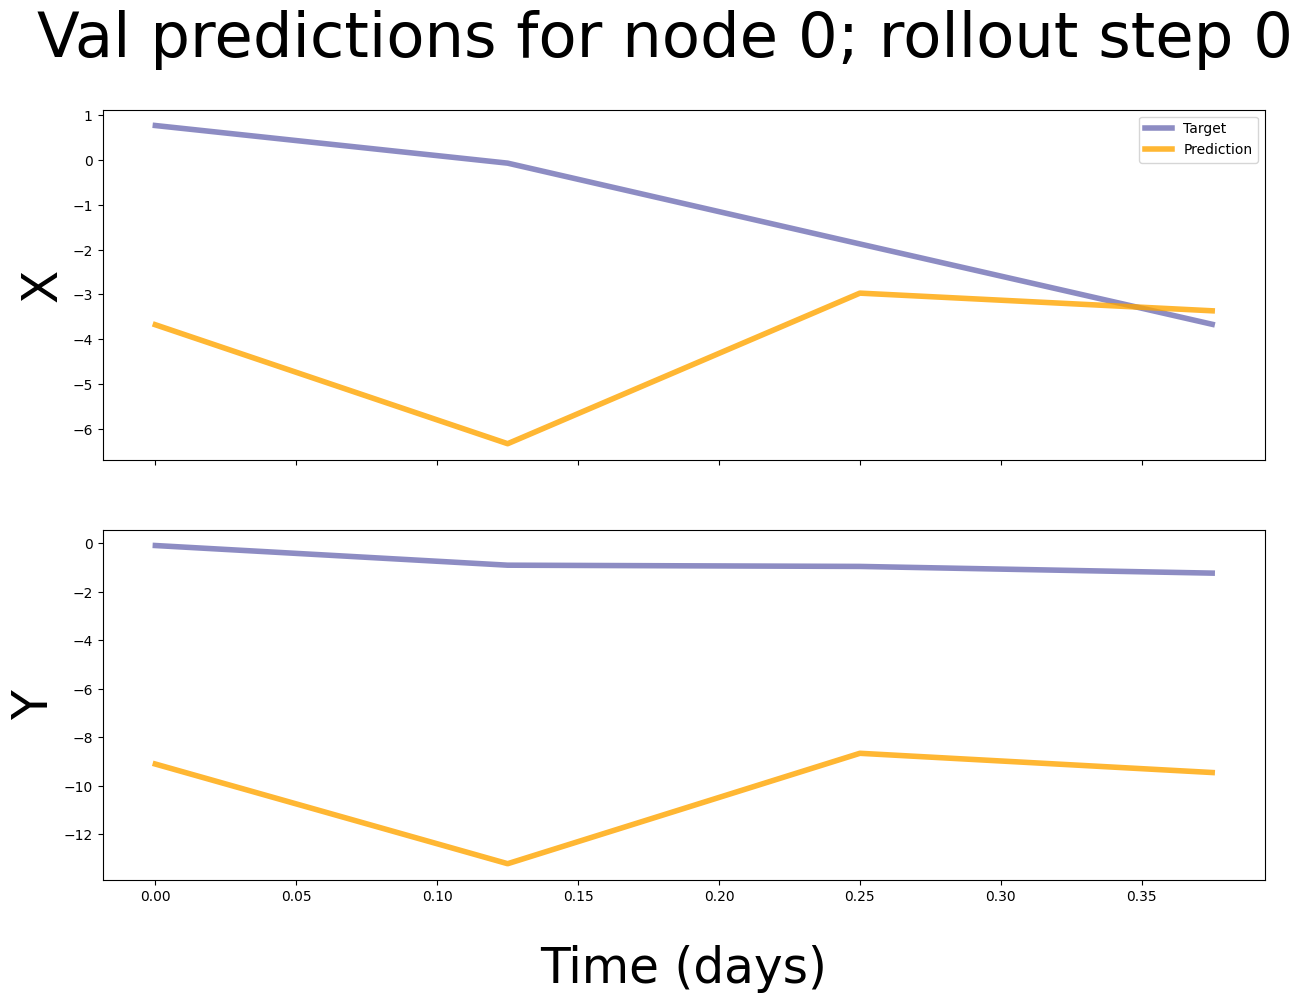

In [87]:
plot_predictions(
    config=get_best_trial_config(study=mia1),
    workdir=get_best_trial_workdir(study=mia1), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    #plot_all=False, # if false, only plot the first 100 
)